Define a new method called aircrafts that receives no arguments and prints only the list of aircraft models (Names)i�r�c�r�a�f�.

In [16]:
import os
import pandas as pd
import requests
from zipfile import ZipFile
from typing import List, Dict, Union
from pydantic import BaseModel
from distances import haversine_distance, Coordinates
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
'''from langchain_openai import OpenAI, ChatOpenAI
import langchain'''
from IPython.display import Markdown, display
import seaborn as sns
#from pandasai import SmartDataframe
from ast import literal_eval

In [9]:
import pandas as pd
airlines_df = pd.read_csv('airlines.csv', on_bad_lines='skip')
airplanes_df = pd.read_csv('airplanes.csv', on_bad_lines='skip')
airports_df = pd.read_csv('airports.csv', on_bad_lines='skip')
routes_df =  pd.read_csv('routes.csv', on_bad_lines='skip')

In [3]:
# Helper functions for plotting flight routes on maps
def plot_route(source_airport, dest_airport, source_lat, source_lon, dest_lat, dest_lon, ax):
    """
    Plots a single flight route on the given axis.
    """
    # Plot the flight route
    ax.plot([source_lon, dest_lon], [source_lat, dest_lat], 'ro-', transform=ccrs.PlateCarree())
    
    # Add airport markers
    ax.plot(source_lon, source_lat, 'bo', markersize=8, transform=ccrs.PlateCarree())
    ax.plot(dest_lon, dest_lat, 'bo', markersize=8, transform=ccrs.PlateCarree())
    
    # Add airport labels
    #ax.text(source_lon + 0.5, source_lat + 0.5, source_airport, transform=ccrs.PlateCarree())
    #ax.text(dest_lon + 0.5, dest_lat + 0.5, dest_airport, transform=ccrs.PlateCarree())

def plot_all_routes(df):
    """
    Plots all flight routes from the given DataFrame on a map.
    """
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

    # Add geographical features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Iterate over the rows in the DataFrame and plot each route
    for _, row in df.iterrows():
        source_airport = row['Source airport']
        dest_airport = row['Destination airport']
        source_lat = row['Source_lat']
        source_lon = row['Source_lon']
        dest_lat = row['Dest_lat']
        dest_lon = row['Dest_lon']

        plot_route(source_airport, dest_airport, source_lat, source_lon, dest_lat, dest_lon, ax)

    # Set the map extent to fit all routes
    max_lon = max(df['Source_lon'].max(), df['Dest_lon'].max())
    min_lon = min(df['Source_lon'].min(), df['Dest_lon'].min())
    max_lat = max(df['Source_lat'].max(), df['Dest_lat'].max())
    min_lat = min(df['Source_lat'].min(), df['Dest_lat'].min())
    ax.set_extent([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5], crs=ccrs.PlateCarree())

    plt.title('All Flight Routes')
    plt.show()


In [4]:
def departing_flights_country(country, internal=False): 
        """
        Retrieve and display information about departing flights from airports in a given country.

        Args:
            country (str): The name of the country for which departing flights will be retrieved.
            internal (bool, optional): If True, only internal flights (with destination in the same country) will be displayed. Defaults to False.

        Returns:
            None

        This method retrieves information about departing flights from airports in the specified country and displays it.
        It joins the routes and airports DataFrames to obtain flight information.
        It filters flights based on the given source country and optionally on whether they are internal.
        If internal is True, only flights with the same source and destination country are displayed.
        If there are no departing flights or no internal flights, appropriate messages are printed.
        """
        # Join on Source airport
        airport_info_1 = routes_df[['Source airport', 'Destination airport']].join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Source airport')
        # Rename the column
        airport_info_1.rename(columns={'Country': 'Source Country', 'Latitude':'Source_lat', 'Longitude': 'Source_lon'}, inplace=True)
        airport_info_1[["Source Country", "Source_lat", "Source_lon", "Source airport", "Destination airport"]]
        
        
        airport_info_2 = airport_info_1.join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Destination airport')
        # Rename the column if needed
        airport_info_2.rename(columns={'Country': 'Destination Country','Latitude':'Dest_lat', 'Longitude': 'Dest_lon'}, inplace=True)
        # Drop the additional index columns
        airport_info_2 = airport_info_2.reset_index(drop=True)
        
        # Filter flights based on the given source country
        source_flights = airport_info_2[airport_info_2['Source Country'] == country]
        source_flights = source_flights[~source_flights.duplicated()]

        del airport_info_1, airport_info_2

        # We only want to count each route 1 time - let's deal with this
        # Create a new column 'Route' that represents the route in a direction-agnostic way
        source_flights['Route'] = source_flights.apply(lambda x: '-'.join(sorted([x['Source airport'], x['Destination airport']])), axis=1)

        # Drop duplicates based on the 'Route' column
        source_flights = source_flights.drop_duplicates(subset=['Route'])

        # Drop the 'Route' column if you don't need it anymore
        source_flights = source_flights.drop('Route', axis=1)

        if internal:
            # Filter for internal flights (destination in the same country)
            source_flights = source_flights[source_flights['Source Country'] == source_flights['Destination Country']]

        # Check if there are any flights to display
        if not source_flights.empty:
            if internal:
                print(f"Internal flights from {country} to destinations in the same country:")
            else:
                print(f"All flights from {country}:")

            plot_all_routes(source_flights)

        else:
            print(f"No internal flights.")
    

    

Internal flights from Italy to destinations in the same country:


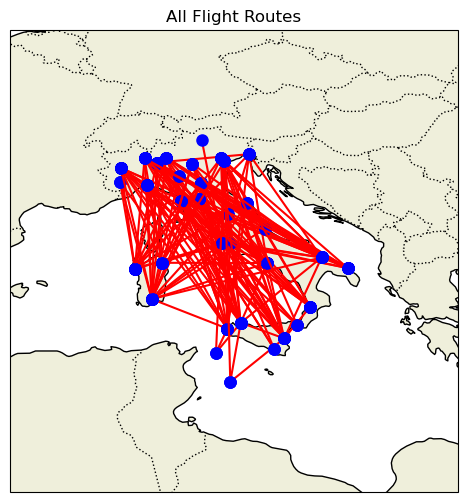

In [10]:
departing_flights_country('Italy', internal=True)

In [14]:
# Join on Source airport
country= 'Italy'
airport_info_1 = routes_df[['Source airport', 'Destination airport']].join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Source airport')
# Rename the column
airport_info_1.rename(columns={'Country': 'Source Country', 'Latitude':'Source_lat', 'Longitude': 'Source_lon'}, inplace=True)
airport_info_1[["Source Country", "Source_lat", "Source_lon", "Source airport", "Destination airport"]]
        
        
airport_info_2 = airport_info_1.join(airports_df.set_index('IATA')[['Country', 'Latitude', 'Longitude']], on='Destination airport')
       # Rename the column if needed
airport_info_2.rename(columns={'Country': 'Destination Country','Latitude':'Dest_lat', 'Longitude': 'Dest_lon'}, inplace=True)
        # Drop the additional index columns
airport_info_2 = airport_info_2.reset_index(drop=True)
        
        # Filter flights based on the given source country
source_flights = airport_info_2[airport_info_2['Source Country'] == country]
source_flights = source_flights[~source_flights.duplicated()]



        # We only want to count each route 1 time - let's deal with this
        # Create a new column 'Route' that represents the route in a direction-agnostic way
source_flights['Route'] = source_flights.apply(lambda x: '-'.join(sorted([x['Source airport'], x['Destination airport']])), axis=1)

        # Drop duplicates based on the 'Route' column
source_flights = source_flights.drop_duplicates(subset=['Route'])

        # Drop the 'Route' column if you don't need it anymore
source_flights = source_flights.drop('Route', axis=1)
source_flights

,Source airport,Destination airport,Source Country,Source_lat,Source_lon,Destination Country,Dest_lat,Dest_lon
115,BDS,ZRH,Italy,40.657600,17.947001,Switzerland,47.464699,8.549170
420,EBA,ACH,Italy,42.760300,10.239400,Switzerland,47.485001,9.560770
421,EBA,FDH,Italy,42.760300,10.239400,Germany,47.671299,9.511490
422,EBA,MUC,Italy,42.760300,10.239400,Germany,48.353802,11.786100
423,EBA,ZRH,Italy,42.760300,10.239400,Switzerland,47.464699,8.549170
...,...,...,...,...,...,...,...,...
65155,MXP,MCT,Italy,45.630600,8.728110,Oman,23.593300,58.284401
66459,FCO,BHX,Italy,41.800278,12.238889,United Kingdom,52.453899,-1.748030
66460,FCO,LTN,Italy,41.800278,12.238889,United Kingdom,51.874699,-0.368333
66562,NAP,LTN,Italy,40.886002,14.290800,United Kingdom,51.874699,-0.368333


In [17]:
source_coords = source_flights.apply(lambda row: Coordinates(lat=row['Source_lat'], lon=row['Source_lon']), axis=1)
dest_coords = source_flights.apply(lambda row: Coordinates(lat=row['Dest_lat'], lon=row['Dest_lon']), axis=1)
# Calculate distances for each flight
source_flights['Distance'] = [haversine_distance(src, dest) for src, dest in zip(source_coords, dest_coords)]
source_flights

,Source airport,Destination airport,Source Country,Source_lat,Source_lon,Destination Country,Dest_lat,Dest_lon,Distance
115,BDS,ZRH,Italy,40.657600,17.947001,Switzerland,47.464699,8.549170,1064.7408
420,EBA,ACH,Italy,42.760300,10.239400,Switzerland,47.485001,9.560770,528.0478
421,EBA,FDH,Italy,42.760300,10.239400,Germany,47.671299,9.511490,549.0394
422,EBA,MUC,Italy,42.760300,10.239400,Germany,48.353802,11.786100,633.4820
423,EBA,ZRH,Italy,42.760300,10.239400,Switzerland,47.464699,8.549170,539.6212
...,...,...,...,...,...,...,...,...,...
65155,MXP,MCT,Italy,45.630600,8.728110,Oman,23.593300,58.284401,5051.2541
66459,FCO,BHX,Italy,41.800278,12.238889,United Kingdom,52.453899,-1.748030,1582.9078
66460,FCO,LTN,Italy,41.800278,12.238889,United Kingdom,51.874699,-0.368333,1470.4022
66562,NAP,LTN,Italy,40.886002,14.290800,United Kingdom,51.874699,-0.368333,1654.4411
